In [1]:
import pandas as pd
import numpy as np

portfolio = pd.Series(["AAA"]*10+["AA"]*10+["A"]*10)
print(portfolio)

0     AAA
1     AAA
2     AAA
3     AAA
4     AAA
5     AAA
6     AAA
7     AAA
8     AAA
9     AAA
10     AA
11     AA
12     AA
13     AA
14     AA
15     AA
16     AA
17     AA
18     AA
19     AA
20      A
21      A
22      A
23      A
24      A
25      A
26      A
27      A
28      A
29      A
dtype: object


In [2]:
#Credit transition matrix (yearly) from: https://www.msci.com/documents/10199/93396227-d449-4229-9143-24a94dab122f
transition_matrix = pd.DataFrame([[.9081, .0833,.0068,.0006,.0012,0,0,0],
                                 [.0070,.9065,.0779,.0064,.0006,.0014,.0002,0],
                                 [.0009,.0227,.9105,.0552,.0074,.0026,.0001,.0006],
                                 [.0002, .0033, .0595, .8693, .0530,.0117,.0012,.0018],
                                 [.0003, .0014,.0067,.0773,.8053,.0884, .0100, .0106],
                                 [0, .0011, .0024, .0043, .0648, .8346, .0407, .0521],
                                 [.0022, 0, .0022, .0130, .0238, .1124, .6486, .1978],
                                 [0,0,0,0,0,0,0,1]],
                                 index=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Default"],
                                columns=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Default"])
print(transition_matrix)

            AAA      AA       A     BBB      BB       B     CCC  Default
AAA      0.9081  0.0833  0.0068  0.0006  0.0012  0.0000  0.0000   0.0000
AA       0.0070  0.9065  0.0779  0.0064  0.0006  0.0014  0.0002   0.0000
A        0.0009  0.0227  0.9105  0.0552  0.0074  0.0026  0.0001   0.0006
BBB      0.0002  0.0033  0.0595  0.8693  0.0530  0.0117  0.0012   0.0018
BB       0.0003  0.0014  0.0067  0.0773  0.8053  0.0884  0.0100   0.0106
B        0.0000  0.0011  0.0024  0.0043  0.0648  0.8346  0.0407   0.0521
CCC      0.0022  0.0000  0.0022  0.0130  0.0238  0.1124  0.6486   0.1978
Default  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   1.0000


In [3]:
#Probabilities for state AAA
print(transition_matrix.loc['AAA'])

AAA        0.9081
AA         0.0833
A          0.0068
BBB        0.0006
BB         0.0012
B          0.0000
CCC        0.0000
Default    0.0000
Name: AAA, dtype: float64


In [4]:
#Get the random move
for _ in range(10):
    print(np.random.RandomState().choice(transition_matrix.index, p=transition_matrix.loc["AAA"].values))
print()
print()
for _ in range(10):
    print(np.random.RandomState().choice(transition_matrix.index, p=transition_matrix.loc["A"].values))

AAA
AAA
AAA
AAA
AA
AAA
AAA
AAA
AAA
AAA


A
A
A
A
A
A
A
A
A
A


In [5]:
#Set initial portfolio of bond's with credit ratings
initial_state = {
    'portfolio': portfolio,
    'default': 0
}

In [6]:
#Function to transition the matrix randomly
def credit_migration(_params, substep, sH, s):
    new_ratings = s['portfolio'].map(lambda x: np.random.RandomState().choice(
  transition_matrix.index, 
  p=transition_matrix.loc[x].values))
    return {"ratings": new_ratings}

#Update the ratings    
def update_portfolio(_params, substep, sH, s, _input):
    return ('portfolio', _input['ratings'])

In [7]:
#Function to value the portfolio, for now just finding default %
def value_portfolio(_params, substep, sH, s):
    return {"default": (s['portfolio'] == "Default").sum() / len(s['portfolio'])}

#Update the value
def update_value(_params, substep, sH, s, _input):
    return ('default', _input['default'])

In [8]:
#Create partial updates
PSUBs = [
    {
        "policies": {
            "migration_policy": credit_migration,
        },
        "variables": {
            "portfolio": update_portfolio,
        }
    },
        {
        "policies": {
            "valuation_policy": value_portfolio,
        },
        "variables": {
            "default": update_value,
        }
    }
]

In [9]:
#Set parameters for 50 runs over 30 years
from cadCAD.configuration.utils import config_sim

sim_config_dict = {
    'T': range(30),
    'N': 50}
c = config_sim(sim_config_dict)

#Create experiment
from cadCAD.configuration import Experiment

exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

#Execute!
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (30, 1, 50, 2)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

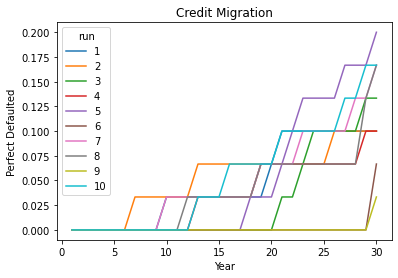

In [10]:
import matplotlib.pyplot as plt

#Plot the first 5 default rates
default_rates = result[result['substep'] == 2].pivot('timestep', 'run', 'default')
default_rates.iloc[:,:10].plot(kind='line')
plt.xlabel("Year")
plt.ylabel("Perfect Defaulted")
plt.title("Credit Migration")
plt.show()

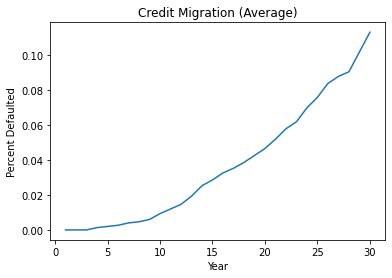

In [11]:
#Find the average default rate across simulations
result[result['substep'] == 2].groupby("timestep")['default'].mean().plot(kind='line')
plt.xlabel("Year")
plt.ylabel("Percent Defaulted")
plt.title("Credit Migration (Average)")
plt.show()

In [12]:
#Find the predicted default rate based on markov chain
transition_matrices = [pd.DataFrame(np.diag([1]*8),index=transition_matrix.index, columns=transition_matrix.columns)]
for _ in range(30):
    transition_matrices.append(transition_matrices[-1].dot(transition_matrix))
    
predicted = pd.Series([1/3, 1/3, 1/3, 0, 0, 0, 0, 0], index=transition_matrix.index)
predicted = pd.Series([predicted.dot(x)['Default'] for x in transition_matrices],index=list(range(31)))
print(predicted)

0     0.000000
1     0.000200
2     0.000558
3     0.001107
4     0.001875
5     0.002885
6     0.004154
7     0.005697
8     0.007524
9     0.009641
10    0.012051
11    0.014756
12    0.017754
13    0.021042
14    0.024615
15    0.028466
16    0.032587
17    0.036971
18    0.041607
19    0.046486
20    0.051597
21    0.056930
22    0.062474
23    0.068217
24    0.074149
25    0.080258
26    0.086534
27    0.092965
28    0.099541
29    0.106251
30    0.113085
dtype: float64


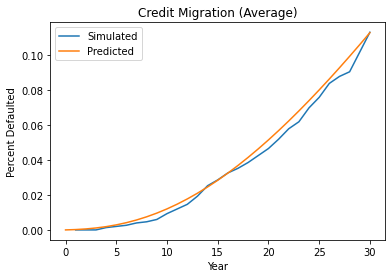

In [13]:
result[result['substep'] == 2].groupby("timestep")['default'].mean().plot(kind='line')
predicted.plot(kind='line')
plt.xlabel("Year")
plt.ylabel("Percent Defaulted")
plt.title("Credit Migration (Average)")
plt.legend(['Simulated', 'Predicted'])
plt.show()

In [14]:
#Convert to monthly transition matrix
u, V = np.linalg.eig(transition_matrix)
P = V
D = np.diag(u)
transition_matrix_monthly = pd.DataFrame(P.dot(D ** (1/12)).dot(np.linalg.inv(P)),
                                        index=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Default"],
                                columns=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Default"])

#Get rid of the rounding error negative numbers
transition_matrix_monthly = transition_matrix_monthly.clip(0)
#Renormalize
transition_matrix_monthly = transition_matrix_monthly.multiply(1/transition_matrix_monthly.sum(axis=1), axis=0)

In [15]:
import pathos
pathos.helpers.shutdown()
configs.clear()

In [ ]:
#Function to transition the matrix randomly, switch to monthly
def credit_migration(_params, substep, sH, s):
    new_ratings = s['portfolio'].map(lambda x: np.random.RandomState().choice(
  transition_matrix_monthly.index, 
  p=transition_matrix_monthly.loc[x].values))
    return {"ratings": new_ratings}

#Update the ratings    
def update_portfolio(_params, substep, sH, s, _input):
    return ('portfolio', _input['ratings'])

#Function to value the portfolio, for now just finding default %
def value_portfolio(_params, substep, sH, s):
    return {"default": (s['portfolio'] == "Default").sum() / len(s['portfolio'])}

#Update the value
def update_value(_params, substep, sH, s, _input):
    return ('default', _input['default'])

#Create partial updates
PSUBs = [
    {
        "policies": {
            "migration_policy": credit_migration,
        },
        "variables": {
            "portfolio": update_portfolio,
        }
    },
        {
        "policies": {
            "valuation_policy": value_portfolio,
        },
        "variables": {
            "default": update_value,
        }
    }
]

sim_config_dict = {
    'T': range(360),
    'N': 50}
c = config_sim(sim_config_dict)

exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)

#Execute!
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 1, 50, 2)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
#Find the predicted default rate based on markov chain for monthly
transition_matrices = [pd.DataFrame(np.diag([1]*8),index=transition_matrix_monthly.index, columns=transition_matrix_monthly.columns)]
for _ in range(360):
    transition_matrices.append(transition_matrices[-1].dot(transition_matrix_monthly))

predicted = pd.Series([1/3, 1/3, 1/3, 0, 0, 0, 0, 0], index=transition_matrix_monthly.index)
predicted = pd.Series([predicted.dot(x)['Default'] for x in transition_matrices],index=list(range(361)))
print(predicted)

In [ ]:
#Plot the predicted vs. simulated
result[result['substep'] == 2].groupby("timestep")['default'].mean().plot(kind='line')
predicted.plot(kind='line')
plt.xlabel("Month")
plt.ylabel("Percent Defaulted")
plt.title("Monthly Credit Migration (Average)")
plt.legend(['Simulated', 'Predicted'])
plt.show()